In [2]:
%env ALL_PROXY=http://127.0.0.1:7897
%env HTTP_PROXY=http://127.0.0.1:7897
%env HTTPS_PROXY=http://127.0.0.1:7897

env: ALL_PROXY=http://127.0.0.1:7897
env: HTTP_PROXY=http://127.0.0.1:7897
env: HTTPS_PROXY=http://127.0.0.1:7897


In [15]:
import tensorflow as tf
from keras.datasets import imdb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import time
import seaborn as sns


In [4]:
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
num_words = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=num_words)

In [6]:
print(f"训练集样本数: {len(X_train)}")
print(f"测试集样本数: {len(X_test)}")
print(f"词汇表大小: {num_words}")

训练集样本数: 25000
测试集样本数: 25000
词汇表大小: 10000


In [7]:
X_train.shape, y_train.shape

((25000,), (25000,))

In [8]:
X_train[0][:10] 
# y_train[0]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

In [9]:
# 获取词索引映射
word_index = imdb.get_word_index()
word_index

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

In [10]:
# 反转映射，整数索引 → 单词
reverse_word_index = {value: key for key, value in word_index.items()}

In [11]:
# 添加保留词
reverse_word_index[0] = '<PAD>'    # 填充
reverse_word_index[1] = '<START>'  # 开始
reverse_word_index[2] = '<UNK>'    # 未知
reverse_word_index[3] = '<UNUSED>' # 未使用

In [12]:
print("\n📊 数据统计信息:")
# 计算序列长度分布
train_lengths = [len(sequence) for sequence in X_train]
test_lengths = [len(sequence) for sequence in X_test]

print(f"训练集序列长度 - 平均: {np.mean(train_lengths):.1f}, 最大: {max(train_lengths)}, 最小: {min(train_lengths)}")
print(f"测试集序列长度 - 平均: {np.mean(test_lengths):.1f}, 最大: {max(test_lengths)}, 最小: {min(test_lengths)}")

# 类别分布
print(f"\n训练集类别分布:")
print(f"  正面评论 (1): {np.sum(y_train == 1)}")
print(f"  负面评论 (0): {np.sum(y_train == 0)}")

print(f"\n测试集类别分布:")
print(f"  正面评论 (1): {np.sum(y_test == 1)}")
print(f"  负面评论 (0): {np.sum(y_test == 0)}")


📊 数据统计信息:
训练集序列长度 - 平均: 238.7, 最大: 2494, 最小: 11
测试集序列长度 - 平均: 230.8, 最大: 2315, 最小: 7

训练集类别分布:
  正面评论 (1): 12500
  负面评论 (0): 12500

测试集类别分布:
  正面评论 (1): 12500
  负面评论 (0): 12500


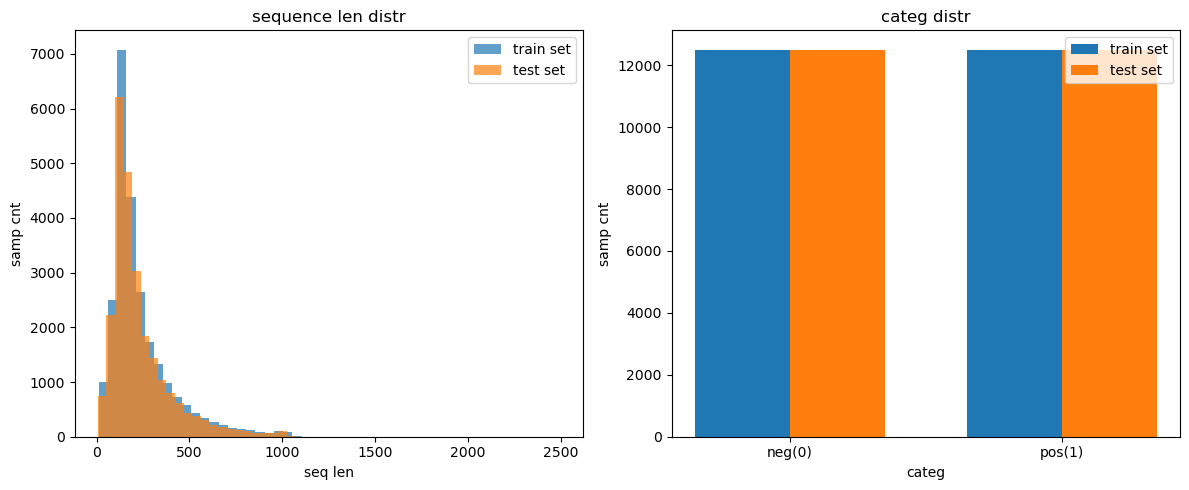

In [16]:
# 可视化序列长度分布
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.hist(train_lengths, bins=50, alpha=0.7, label='train set')
plt.hist(test_lengths, bins=50, alpha=0.7, label='test set')
plt.title('sequence len distr')
plt.xlabel('seq len')
plt.ylabel('samp cnt')
plt.legend()

# 可视化类别分布
plt.subplot(1, 2, 2)
labels = ['neg(0)', 'pos(1)']
train_counts = [np.sum(y_train == 0), np.sum(y_train == 1)]
test_counts = [np.sum(y_test == 0), np.sum(y_test == 1)]
x = np.arange(len(labels))
width = 0.35
plt.bar(x - width/2, train_counts, width, label='train set')
plt.bar(x + width/2, test_counts, width, label='test set')
plt.title('categ distr')
plt.xlabel('categ')
plt.ylabel('samp cnt')
plt.xticks(x, labels)
plt.legend()
plt.tight_layout()
plt.savefig('img/imdb_data_stats.png')
plt.show()

In [14]:
print("\n🔍 示例评论解码:")
for i in range(5):
    decoded_review = ' '.join([reverse_word_index.get(word, '?') for word in X_train[i]])
    sentiment = "正面" if y_train[i] == 1 else "负面"
    print(f"\n评论 {i+1} ({sentiment}):")
    print(decoded_review[:200] + "...")  # 只显示前200字符


🔍 示例评论解码:

评论 1 (正面):
<START> as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room <UNK> it so heart shows to years of every n...

评论 2 (负面):
<START> thought solid thought senator do making to is spot nomination assumed while he of jack in where picked as getting on was did hands fact characters to always life thrillers not as me can't in a...

评论 3 (负面):
<START> as there in at by br of sure many br of proving no only women was than doesn't as you never of hat night that with ignored they bad out superman plays of how star so stories film comes defense...

评论 4 (正面):
<START> of <UNK> <UNK> they halfway of identity went plot actors watch of share was well these can this only <UNK> ten so failing feels only novak killer theo of bill br <UNK> would find of films saw ...

评论 5 (负面):
<START> sure themes br only acting i i was favourite as on she they hat but already most was scares minor if flas

In [17]:
def create_small_samples(X_trian, y_train, reverse_word_index,
                         sample_size=1000,
                         feature_type='tfidf',
                         max_features=1000,
                         use_pca=False, n_components=100):
    """
    Parameters:
    - sample_size: 小样本大小
    - feature_type: 特征类型 ('tfidf', 'count', 'binary')
    - max_features: 最大特征数
    - use_pca: 是否使用PCA降维
    - n_components: PCA降维后的维度
    """
    print(f"🔧 准备IMDb小样本数据集 (样本数: {sample_size})...")

    indices = np.random.choice(len(X_train), sample_size, replace=False)
    X_sample_train = X_train[indices]
    y_sample_train = y_train[indices]

    print(f"选中的样本数: {len(X_sample_train)}")
    
    # 1. 将序列转换回原始文本
    print("\n🔄 将序列转换为原始文本...")
    X_sample_text = []

    for sequence in X_sample_train:
        # 跳过保留词(0,1,2,3)
        words = [reverse_word_index.get(word_index, '?') for word_index in sequence if word_index >= 4 ]
        text = ' '.join(words)
        X_sample_text.append(text)
    
    print(f"转换后的文本样本示例:")
    for i in range(3):
        print(f"  样本 {i+1}: '{X_sample_text[i][:100]}...'")
    
    # 2. 特征提取 - 文本向量化
    print(f"\n📊 进行文本特征提取 ({feature_type.upper()})...")
    if feature_type == 'tfidf':
        vectorizer = TfidfVectorizer(
            max_features=max_features,
            stop_words='english',  # 移除英文停用词{to, the, a, ...}
            lowercase=True,
            min_df=2,  # 最小文档频率
            max_df=0.95  # 最大文档频率
        )
    elif feature_type == 'count':
        vectorizer = CountVectorizer(
            max_features=max_features,
            stop_words='english',
            lowercase=True,
            min_df=2
        )
    elif feature_type == 'binary':
        vectorizer = CountVectorizer(
            max_features=max_features,
            stop_words='english',
            lowercase=True,
            min_df=2,
            binary=True  # 二进制特征
        )

    # 拟合并转换
    X_sample_features = vectorizer.fit_transform(X_sample_text)
    feature_names = vectorizer.get_feature_names_out()      # 获得输出特征名用于变换
    
    print(f"特征提取后形状: {X_sample_features.shape}")
    print(f"词汇表大小: {len(feature_names)}")

    # 3. 转换为稠密数组（对于SVM和MLP需要）
    print("\n🔄 转换为稠密数组...")
    X_sample_dense = X_sample_features.toarray()
    print(f"稠密数组形状: {X_sample_dense.shape}")

    # 4. 数据标准化
    print("\n📊 数据标准化...")
    scaler = StandardScaler()
    X_sample_scaled = scaler.fit_transform(X_sample_dense)
    print(f"标准化后形状: {X_sample_scaled.shape}")

    # 5. PCA降维（对SVM特别重要）
    if use_pca:
        print(f"\n📊 应用PCA降维 (n_components={n_components})...")
        pca = PCA(
            n_components=n_components,
            random_state=42,
        )
        X_sample_pca = pca.fit_transform(X_sample_scaled)
        print(f"PCA降维后形状: {X_sample_pca.shape}")
        print(f"保留的方差比例: {np.sum(pca.explained_variance_ratio_):.4f}")

        # 返回pca版本
        return X_sample_pca, y_sample_train, vectorizer, scaler, pca, feature_names
    else:
        return X_sample_scaled, y_sample_train, vectorizer, scaler, None, feature_names

In [19]:
sample_size = 1000  # 小样本大小
feature_type = 'tfidf'  # 'tfidf', 'count', 'binary'
max_features = 2000  # 最大特征数
use_pca = True  # 对SVM很重要
n_components = 100  # PCA降维目标维度

X_sample, y_sample, vectorizer, scaler, pca, feature_names = create_small_samples(
    X_train, y_train, reverse_word_index,
    sample_size=sample_size,
    feature_type=feature_type,
    max_features=max_features,
    use_pca=use_pca,
    n_components=n_components
)

🔧 准备IMDb小样本数据集 (样本数: 1000)...
选中的样本数: 1000

🔄 将序列转换为原始文本...
转换后的文本样本示例:
  样本 1: 'our charles is reminiscent ten but you to is did but very entertaining was cinema in can femme matth...'
  样本 2: 'was least french was did hilarious to several that was with had set deep in wife as watch doesn't de...'
  样本 3: 'was one in act that in of tragedy ways side while said concerns characters actresses in year nuclear...'

📊 进行文本特征提取 (TFIDF)...
特征提取后形状: (1000, 2000)
词汇表大小: 2000

🔄 转换为稠密数组...
稠密数组形状: (1000, 2000)

📊 数据标准化...
标准化后形状: (1000, 2000)

📊 应用PCA降维 (n_components=100)...
PCA降维后形状: (1000, 100)
保留的方差比例: 0.2336


In [21]:
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42, 
    stratify=y_sample,      # 近似保持原始比例
)

In [ ]:
svm_model = SVC(
    kernel='linear',     # 线性核在文本分类中通常表现良好
    random_state=42,
    max_iter=1000,
    probability=True,
    verbose=True,
)

start_time = time.time()
svm_model.fit(X_train_small, y_train_small)
training_time = time.time() - start_time

print(f"✅ SVM训练完成！训练时间: {training_time:.2f}秒")

[LibSVM].WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -11.793050, rho = -0.026052
nSV = 360, nBSV = 0
Total nSV = 360
.WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -11.347368, rho = -0.053457
nSV = 388, nBSV = 0
Total nSV = 388
.WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -11.883320, rho = -0.068616
nSV = 393, nBSV = 0
Total nSV = 393
.WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -11.607235, rho = -0.108646
nSV = 381, nBSV = 0
Total nSV = 381
.WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -11.511149, rho = -0.008868
nSV = 377, nBSV = 0
Total nSV = 377
.WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -10.655260, rho = 0.077035
nSV = 431, nBSV = 0
Total nSV = 431
✅ SVM训练完成！训练时间: 0.54秒


/home/anemperorduck/anaconda3/envs/tf210/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [23]:
# 模型性能评估函数
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    # 计算指标
    accuracy = accuracy_score(y_test, y_pred)       # 准确率不需要加权平均
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"\n{model_name} 模型评估结果:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

svm_metrics_small = evaluate_model(svm_model, X_test_small, y_test_small, "SVM")


SVM 模型评估结果:
Accuracy:  0.7250
Precision: 0.7256
Recall:    0.7250
F1 Score:  0.7238


In [26]:
import joblib
import os
from datetime import datetime

# 创建保存目录
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

def save_model(model, scaler=None, model_name="model", dataset_name="imdb"):
    """
    保存模型和预处理器到本地
    
    Parameters:
    - model: 训练好的模型 (SVM或MLP)
    - scaler: 预处理器 (StandardScaler等)，可选
    - model_name: 模型名称 (如 "svm", "mlp")
    - dataset_name: 数据集名称
    """

    # 创建唯一时间戳
    timestamp = datetime.now().strftime("%m%d_%H%M")

    # 构建文件名
    model_filename = f'{model_name}_{dataset_name}_{timestamp}.joblib'
    scaler_filename = f'{model_name}_{dataset_name}_scaler_{timestamp}.joblib'

    # 完整路径 
    model_path = os.path.join(MODEL_DIR, model_filename)
    scaler_path = os.path.join(MODEL_DIR, scaler_filename)
    
    # 保存模型
    joblib.dump(model, model_path)
    print(f"✅ 模型已保存到: {model_path}")
    
    # 保存预处理器（如果存在）
    if scaler is not None:
        joblib.dump(scaler, scaler_path)
        print(f"✅ 预处理器已保存到: {scaler_path}")
    
    return model_path, scaler_path if scaler else None

In [27]:
svm_model_path, svm_scaler_path = save_model(
    model=svm_model,
    scaler=scaler, 
    model_name="svm",
    dataset_name="imdb_small"
)

✅ 模型已保存到: models/svm_imdb_small_0107_1227.joblib
✅ 预处理器已保存到: models/svm_imdb_small_scaler_0107_1227.joblib


In [28]:
# 创建MLP模型
mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64),  # 两个隐藏层
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size=32,
    learning_rate='adaptive',
    max_iter=200,
    random_state=42,
    verbose=True,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10
)

start_time = time.time()
mlp_model.fit(X_train_small, y_train_small)
training_time = time.time() - start_time
print(f"✅ MLP训练完成！训练时间: {training_time:.2f}秒")

Iteration 1, loss = 0.77654221
Validation score: 0.700000
Iteration 2, loss = 0.42541037
Validation score: 0.750000
Iteration 3, loss = 0.31491167
Validation score: 0.762500
Iteration 4, loss = 0.23356935
Validation score: 0.762500
Iteration 5, loss = 0.17647312
Validation score: 0.737500
Iteration 6, loss = 0.13497206
Validation score: 0.737500
Iteration 7, loss = 0.10282956
Validation score: 0.737500
Iteration 8, loss = 0.07891424
Validation score: 0.737500
Iteration 9, loss = 0.06114241
Validation score: 0.737500
Iteration 10, loss = 0.04740892
Validation score: 0.712500
Iteration 11, loss = 0.03778932
Validation score: 0.712500
Iteration 12, loss = 0.02995749
Validation score: 0.712500
Iteration 13, loss = 0.02433842
Validation score: 0.725000
Iteration 14, loss = 0.02004416
Validation score: 0.725000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
✅ MLP训练完成！训练时间: 1.23秒


In [29]:
mlp_metrics_small = evaluate_model(mlp_model, X_test_small, y_test_small, "MLP")


MLP 模型评估结果:
Accuracy:  0.7750
Precision: 0.7771
Recall:    0.7750
F1 Score:  0.7751


In [30]:
mlp_model_path, mlp_scaler_path = save_model(
    model=mlp_model,
    scaler=scaler, 
    model_name="mlp",
    dataset_name="imdb_small"
)

✅ 模型已保存到: models/mlp_imdb_small_0107_1255.joblib
✅ 预处理器已保存到: models/mlp_imdb_small_scaler_0107_1255.joblib


In [33]:
def plot_mlp_training_curves(mlp_model, model_name="MLP_IMDb"):
    """
    绘制MLP训练曲线
    """
    if not hasattr(mlp_model, 'loss_curve_'):
        print("⚠️  MLP模型没有loss_curve_属性，无法绘制训练曲线")
        return
    
    plt.figure(figsize=(12, 6))
    
    # 绘制损失曲线
    plt.plot(mlp_model.loss_curve_, 'b-', linewidth=2, label='train loss')
    plt.title(f'{model_name} train loss curve', fontsize=14)
    plt.xlabel('iter cnt')
    plt.ylabel('loss val')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plt.savefig(f'img/{model_name.lower()}_loss_curve_{timestamp}.png')
    plt.show()
    
    print(f"✅ 训练曲线已保存")
    
    # 如果有验证分数，也绘制
    if hasattr(mlp_model, 'validation_scores_'):
        plt.figure(figsize=(12, 6))
        plt.plot(mlp_model.validation_scores_, 'g-', linewidth=2, label='vallid pre al')
        plt.title(f'{model_name} valid pre curve', fontsize=14)
        plt.xlabel('iter cnt')
        plt.ylabel('pre al')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'img/{model_name.lower()}_val_accuracy_{timestamp}.png')
        plt.show()

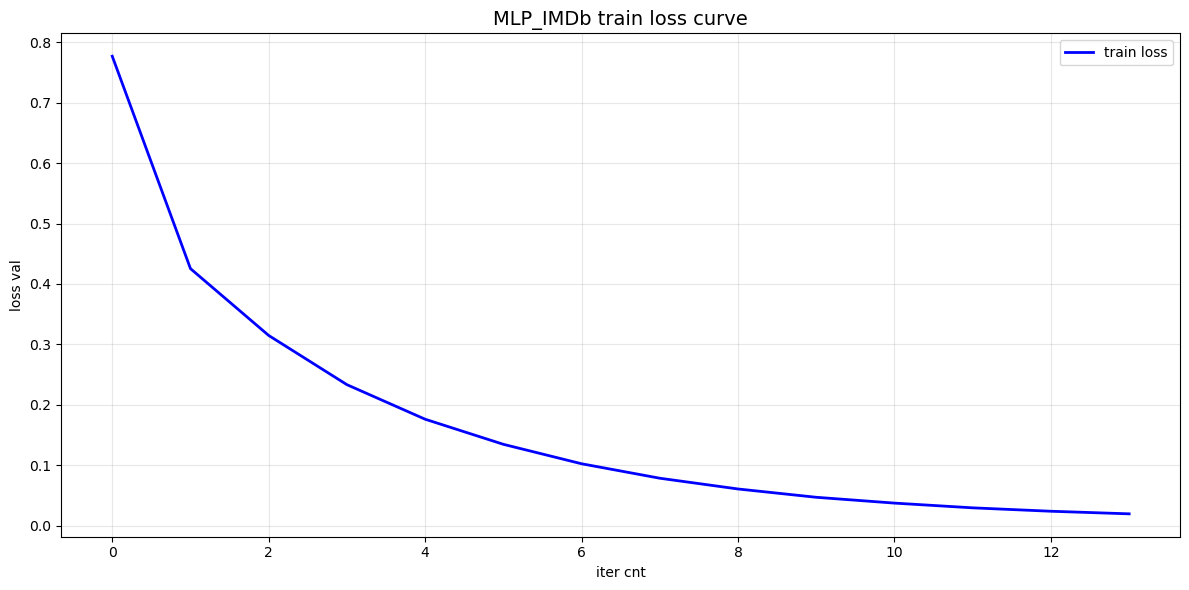

✅ 训练曲线已保存


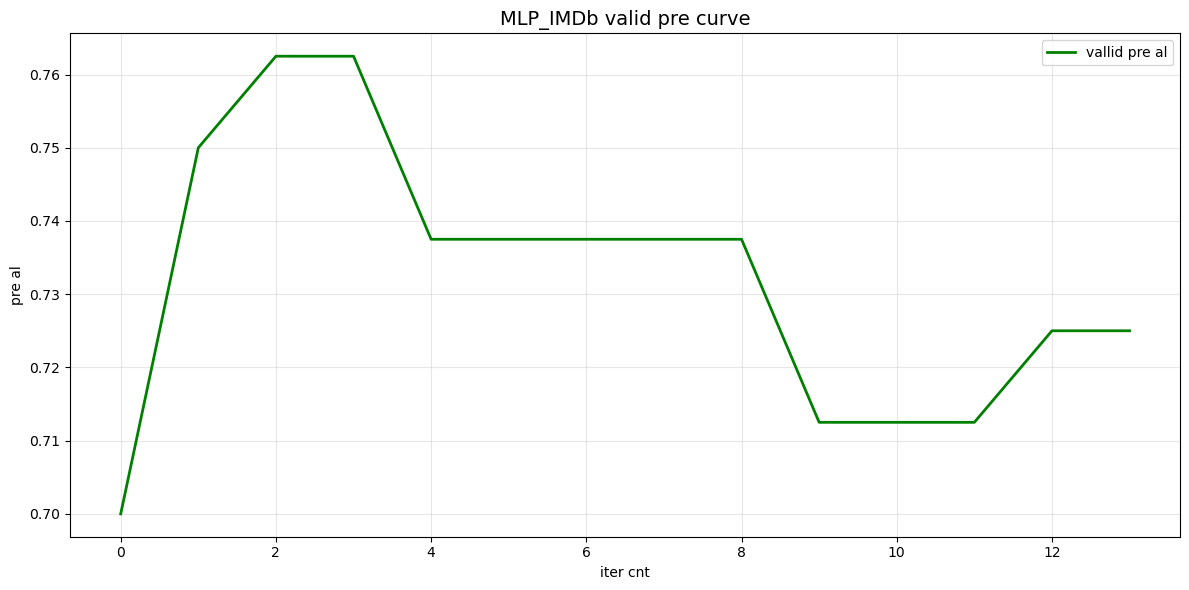

In [34]:
plot_mlp_training_curves(mlp_model)